In this notebook we perform the blind source separation of the maps, making using of the wavelet-transformed dataset and the GMCA algorithm. We check results by plotting the maps and their power spectra. For details, refer to the [paper](https://arxiv.org/abs/2006.05996).

In [1]:
# importing the required packages
import numpy as np
import h5py
import matplotlib.pyplot as plt
import healpy as hp

import sys
sys.path.insert(1, '../scripts')
import gmca4im_lib2 as g4i

#### Load the datacube
We load the maps we assembled in the [previous notebook](./tut_1_preparation.ipynb).

In [86]:
file = h5py.File('../sim_10MHz.hd5','r')

In [67]:
# let's have a look at what it contains
file.keys()

<KeysViewHDF5 ['cosmological_signal', 'frequencies', 'gal_ff', 'gal_synch', 'noise', 'point_sources']>

In [68]:
# let's define a list with the components of the simulation
components = list(file.keys()); components.remove('frequencies')
# and save the channel frequencies
nu_ch = np.array(file['frequencies'])

In [74]:
print(f'working with {len(nu_ch)} channels, from {min(nu_ch)} to {max(nu_ch)} MHz')
print(f'i.e. channels are {nu_ch[1]-nu_ch[0]} MHz thick')

working with 40 channels, from 905.0 to 1295.0 MHz
i.e. channels are 10.0 MHz thick


### Wavelet transform of the maps

GMCA is a blind source separation algorithm that relies on the morphological features that compose the sought-after components. To that purpose, such components are assumed to admit a sparse distribution in an adapted signal representation. In which representation are our foregrounds sparse?

We make use of the Starlet wavelet dictionary, we transform the observed maps in wavelet space. 

In [104]:
# Preparing the observed map (sum of all components + noise):

npix = np.shape(file['cosmological_signal'])[1]
obs_maps = np.zeros((len(nu_ch),npix))

for c in components:
    print(c)
    obs_maps += np.array(file[c])
    
## remove mean from maps
obs_maps = np.array([[obs_maps[i] - np.mean(obs_maps[i],axis=0)] for i in range(len(nu_ch))])
obs_maps = obs_maps[:,0,:]


cosmological_signal
gal_ff
gal_synch
noise
point_sources


Running the wavelet transform of maps:

In [76]:
## wavelet transform it
X_wt = g4i.wavelet_transform(obs_maps)


Wavelet transforming the data . . .
. . completed in 8.13 minutes



#### Let's have a look at the eigenvalues

The principal eigenvalues of the covariance matrix of the data-cubes tell us about the transition between highly correlated modes in frequency (foregrounds) and uncorrelated modes (signal and noise), and give us a hint about how many sources the blind source separation method has to look after.

In [78]:
## function for extracting eigenvalues
def EVN(X):
    C_ij = np.cov(X) #Obtain frequency covariance matrix for input data
    # Get the eigenvalues and eigenvectors of covariance matrix:
    eigenval, eigenvec = np.linalg.eigh(C_ij)
    eigenval = eigenval[::-1] # largest eigenvals first
    del eigenvec

    return eigenval

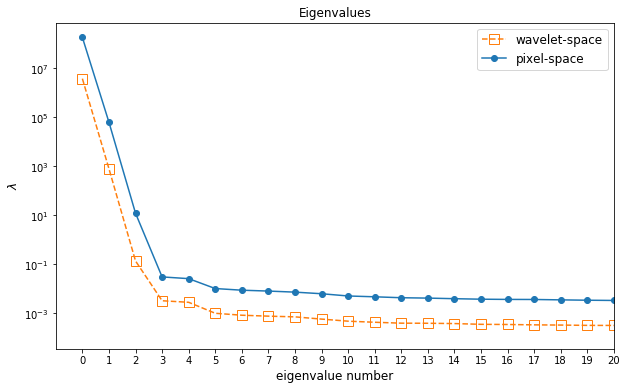

In [79]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

plt.semilogy(EVN(X_wt),'--s',c='#ff7f0e',mfc='none',markersize=10,label='wavelet-space')
plt.semilogy(EVN(obs_maps),'-o',c='#1f77b4',markersize=6,label='pixel-space')

plt.legend(fontsize=12)
x_ticks = np.arange(25)
ax = plt.gca()
ax.set(xlim=[-1,20],xticks=x_ticks,xlabel="eigenvalue number",ylabel="$\\lambda$",title='Eigenvalues');


# Let's run GMCA

GMCA promotes sparsity in the decomposition process of the data-cubes and estimates the mixing matrix A as in equation (4) of the [reference paper](https://arxiv.org/abs/2006.05996). See also references therein for more details on how to use GMCA. Here we schematically describe the main parameters.

In [80]:
################   GMCA PARAMETERS   ##################
n_s   = 3   # number of sources to be estimated
mints = 0.1 # min threshold (what is sparse compared to noise?)
nmax  = 100 # number of iterations (usually 100 is safe)
L0    = 0   # switch between L0 norm (1) or L1 norm (0)
#######################################################

# initial guess for the mixing matrix?
# i.e. we could start from PCA-determined mix matrix
AInit = None

# we can impose a column of the mixing matrix
ColFixed = None

# we can whiten the data
whitening = False; epsi = 1e-3

# estimated mixing matrix:
Ae = g4i.run_GMCA(X_wt,AInit,n_s,mints,nmax,L0,ColFixed,whitening,epsi)


Now running GMCA . . .
. . completed in 3.46 minutes



#### Let's have a look at the column of the mixing matrix

To check what kind of sources GMCA distinguished.

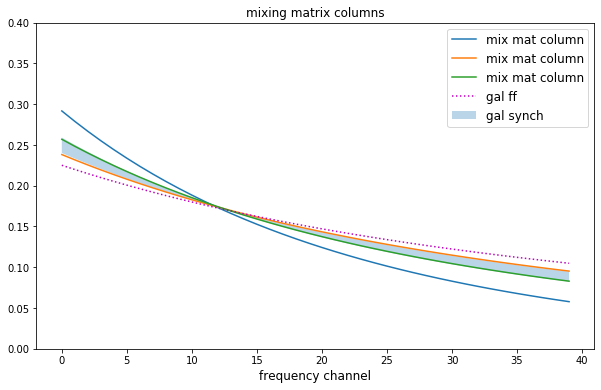

In [83]:
# gal freefree spectral index for reference
FF_col = np.array([nu_ch**(-2.13)]).T 

# gal synchrotron spectral index region for reference
sync_A = np.array([nu_ch**(-3.2)]).T; y1 = sync_A/np.linalg.norm(sync_A)
sync_B = np.array([nu_ch**(-2.6)]).T; y2 = sync_B/np.linalg.norm(sync_B)

### actual plotting
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

x = np.arange(0,len(nu_ch))

plt.fill_between(x,y1.T[0],y2.T[0],alpha=0.3,label='gal synch')
plt.plot(abs(Ae/np.linalg.norm(Ae,axis=0)),label='mix mat column')
plt.plot(FF_col/np.linalg.norm(FF_col),'m:',label='gal ff')

ax = plt.gca()
ax.set(ylim=[0.0,0.4],xlabel="frequency channel",title='mixing matrix columns');
plt.legend(fontsize=12);

### How well did we recover the foregrounds?

The cleaned maps are assembled as in equation (13) of [reference paper](https://arxiv.org/abs/2006.05996).

In [99]:
#### reconstructed maps by GMCA
piA = np.linalg.inv(Ae.T@Ae)@Ae.T
# reproject onto original maps 
Se_sph = piA@obs_maps # LS estimate of the sources in the pixel domain
X_gmca = Ae@Se_sph; del Se_sph, piA

#### Mollweide projections

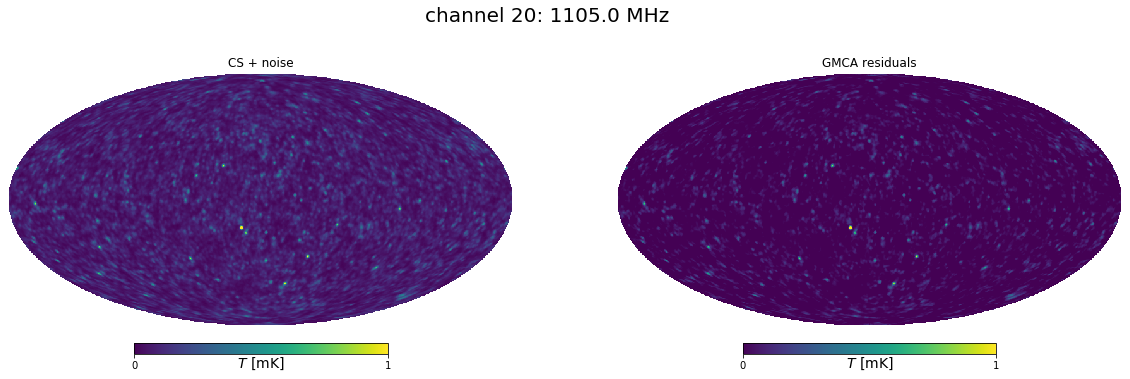

In [100]:
# pick a channel number to image
ich = 20

map_input = np.array(file['cosmological_signal'])[ich]+np.array(file['noise'])[ich] 
residuals = obs_maps[ich]-X_gmca[ich]

fig = plt.figure(figsize=(20, 6))
fig.suptitle(f'channel {ich}: {nu_ch[ich]} MHz',fontsize=20)
ax1 = fig.add_subplot(1,2,1)
plt.axes(ax1)
hp.mollview(map_input,min=0,max=1,title='CS + noise',unit=r'$T$ [mK]',hold=True)
ax2 = fig.add_subplot(1,2,2)
plt.axes(ax2)
hp.mollview(residuals,min=0,max=1,title='GMCA residuals',unit=r'$T$ [mK]',hold=True)

del map_input, residuals

#### Angular power spectra 

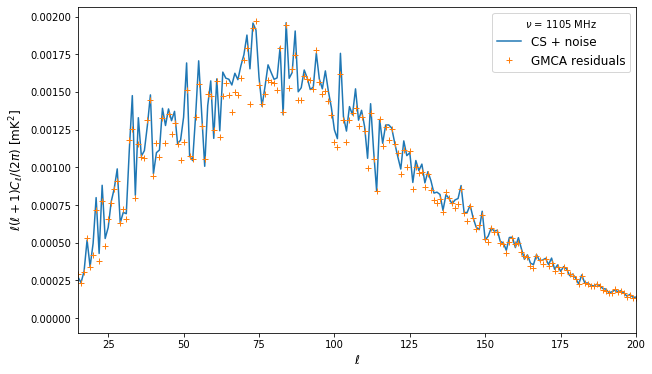

In [103]:
# pick a channel number
ich = 20

map_input = np.array(file['cosmological_signal'])[ich]+np.array(file['noise'])[ich] 
residuals = obs_maps[ich]-X_gmca[ich]

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

ell, y = g4i.plot_cl(map_input)
plt.plot(ell, y,'-',c='#1f77b4',label='CS + noise');
ell, y = g4i.plot_cl(residuals)
plt.plot(ell,y,'+',c='#ff7f0e',label='GMCA residuals')

plt.legend(title='$\\nu$ = '+'%4.f'%nu_ch[ich]+' MHz',fontsize=12)
ax = plt.gca()
ax.set(xlim=[15,200],xlabel="$\\ell$",ylabel="$\\ell(\\ell+1)C_{\\ell}/(2\\pi)$ [mK$^2$]");


#### Radial power spectra 

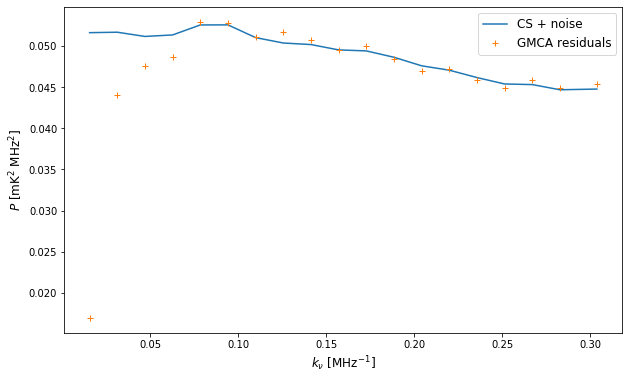

In [102]:
# we are working full-sky, so we pick all available lines-of-sight
indexes_los = np.arange(npix)

map_input = np.array(file['cosmological_signal'])+np.array(file['noise']) 
residuals = obs_maps-X_gmca

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

k, P = g4i.plot_nuPk(map_input,indexes_los,nu_ch)
plt.plot(k, P,'-',c='#1f77b4',label='CS + noise')

k, P = g4i.plot_nuPk(residuals,indexes_los,nu_ch)
plt.plot(k, P,'+',c='#ff7f0e',label='GMCA residuals')

plt.legend(fontsize=12)
ax = plt.gca()
ax.set(xlabel="$k_{\\nu}$ [MHz$^{-1}$]",ylabel="$P$ [mK$^2$ MHz$^2$]");
